# Image에서 Human Detection

In [8]:
import cv2
import numpy as np
import pandas as pd
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

body_cascade = cv2.CascadeClassifier('haarcascade_fullbody.xml')

img = cv2.imread('B.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

body = body_cascade.detectMultiScale(gray, 1.3, 1)

for (x,y,w,h) in body:
    cv2.rectangle(img,(x, y),(x+w, y+h),(0,255,0),2)
cv2.imwrite('img.jpg',img)

True

In [67]:
import cv2
import numpy as np
import pandas as pd
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

body_cascade = cv2.CascadeClassifier('haarcascade_fullbody.xml')

img = cv2.imread('Grab2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

body = body_cascade.detectMultiScale(gray, 1.3, 1)

for (x,y,w,h) in body:
    cv2.rectangle(img,(x, y),(x+w, y+h),(0,255,0),2)
cv2.imwrite('g.jpg',img)

True

<p>=> openCV에서 제공하는 것은 몸만 포함하는 것</p>
<p>=> 얼굴 부분은 몸 범위에 포함하지 않음</p>

# INRIAPerson Dataset을 이용하여 Human Detection

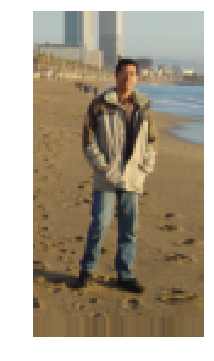

In [15]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
filename = "INRIAPerson/70X134H96/Test/pos/crop_000001a.png"
img = cv2.imread(filename)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

=> INRIAPerson Dataset sample : 70x134 image, total 1132개의 image

In [51]:
# Taking a glimpse at the histogram of oriented gradients (HOG)

import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import glob

win_size = (72, 144)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
num_bins = 9
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

In [52]:
random.seed(42)
X_pos = []

for i in glob.glob('INRIAPerson/96X160H96/Train/pos/*.png'):
    img = cv2.imread(i)
    if img is None:
        print('Could not find image %s' % filename)
        continue
    X_pos.append(hog.compute(img, (64, 64)))
    
X_pos = np.array(X_pos, dtype=np.float32)
y_pos = np.ones(X_pos.shape[0], dtype=np.int32)
X_pos.shape, y_pos.shape

((2416, 4896, 1), (2416,))

In [53]:
# Generating negatives

import os

hroi = 160
wroi = 96
X_neg = []

for negfile in glob.glob('INRIAPerson/Test/neg/*.png'):
    img = cv2.imread(negfile)
    img = cv2.resize(img, (512, 512))
    for j in range(5):
        rand_y = random.randint(0, img.shape[0] - hroi)
        rand_x = random.randint(0, img.shape[1] - wroi)
        roi = img[rand_y:rand_y + hroi, rand_x:rand_x + wroi, :]
        X_neg.append(hog.compute(roi, (64, 64)))
        
for negfile in glob.glob('INRIAPerson/Train/neg/*.png'):
    img = cv2.imread(negfile)
    img = cv2.resize(img, (512, 512))
    for j in range(5):
        rand_y = random.randint(0, img.shape[0] - hroi)
        rand_x = random.randint(0, img.shape[1] - wroi)
        roi = img[rand_y:rand_y + hroi, rand_x:rand_x + wroi, :]
        X_neg.append(hog.compute(roi, (64, 64)))
        
X_neg = np.array(X_neg, dtype=np.float32)
y_neg = -np.ones(X_neg.shape[0], dtype=np.int32)
X_neg.shape, y_neg.shape

((6060, 4896, 1), (6060,))

In [54]:
X = np.concatenate((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))

from sklearn import model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
def train_svm(X_train, y_train):
    svm = cv2.ml.SVM_create()
    svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
    return svm

def score_svm(svm, X, y):
    from sklearn import metrics
    _, y_pred = svm.predict(X)
    return metrics.accuracy_score(y, y_pred)

svm = train_svm(X_train, y_train)
score_svm(svm, X_train, y_train)
score_svm(svm, X_test, y_test)

0.9009433962264151

Bootstrapping the model

In [65]:
score_train = []
score_test = []

for j in range(6):
    svm = train_svm(X_train, y_train)
    score_train.append(score_svm(svm, X_train, y_train))
    score_test.append(score_svm(svm, X_test, y_test))
    
    # 테스트 세트에서 오탐을 찾음
    _, y_pred = svm.predict(X_test)
    false_pos = np.logical_and((y_test.ravel() == -1), (y_pred.ravel() == 1))
    
    if not np.any(false_pos):
        print('done')
        break
        
    # 오탐을 추가한 후 절차 반복
    X_train = np.concatenate((X_train, X_test[false_pos, :]), axis=0)
    y_train = np.concatenate((y_train, y_test[false_pos]), axis=0)
    
score_train
score_test

[0.9044811320754716,
 0.9050707547169812,
 0.9056603773584906,
 0.90625,
 0.9044811320754716,
 0.9044811320754716]

<p> => 70X134보다 96X160 Image가 학습이 더 잘되었음 </p>
<p> => win_size, block_size etc..에 따라 Accuracy가 다르게 나옴</p>
<p> => Train data 수에 따라 학습률이 다름 </p>

Detecting pedestrians in a larger image

In [56]:
img_test = cv2.imread('Grab2.jpg')

stride = 16
found = []
for ystart in np.arange(0, img_test.shape[0], stride):
    for xstart in np.arange(0, img_test.shape[1], stride):
        if ystart + hroi > img_test.shape[0]:
            continue
        if xstart + wroi > img_test.shape[1]:
            continue
            
        roi = img_test[ystart:ystart + hroi, xstart:xstart + wroi, :]
        feat = np.array([hog.compute(roi, (64, 64))])
        _, ypred = svm.predict(feat)
        
        if np.allclose(ypred, 1):
            found.append((ystart, xstart, hroi, wroi))

In [57]:
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

In [58]:
rho, _, _ = svm.getDecisionFunction(0)
sv = svm.getSupportVectors()
hog.setSVMDetector(np.append(sv[0, :].ravel(), rho))

In [59]:
hogdef = cv2.HOGDescriptor()

In [60]:
hogdef.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [61]:
found, _ = hogdef.detectMultiScale(img_test)

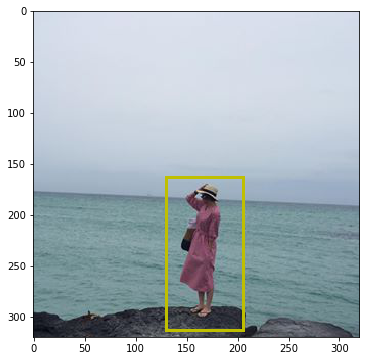

In [62]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))

from matplotlib import patches

for f in found:
    ax.add_patch(patches.Rectangle((f[0], f[1]), f[2], f[3], color='y', linewidth=3, fill=False))
plt.savefig('detected.png')

# Grab-Cut Algorithm

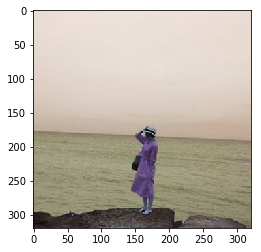

In [23]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('Grab2.jpg')
plt.imshow(img)

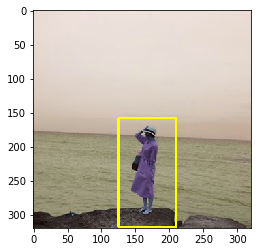

In [38]:
# sample rectangle range
img = cv2.imread('Grab2.jpg')
cv2.rectangle(img,(f[0]-5, f[1]-5), (f[0]+f[2]+5, f[1]+f[3]+5),(255,255,0),2)
plt.imshow(img)

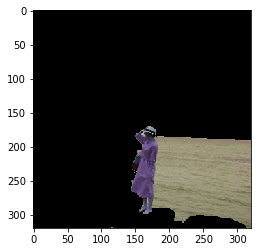

In [36]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('Grab2.jpg')

mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)
rect = (f[0]-5, f[1]-5, f[0]+f[2]+5, f[1]+f[3]+5)  # = (x, y, w, h)

# (입력 이미지, 분할 결과, 경계 직사각형, 배경 모델, 전경 모델, 실행할 반복 크기, 모드)
cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
img = img * mask2[:,:,np.newaxis]

plt.imshow(img)

=> 기존의 fitting system version

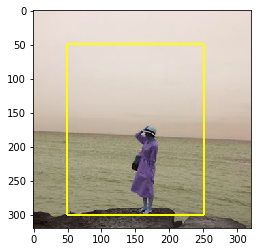

In [33]:
# sample rectangle range
img = cv2.imread('Grab2.jpg')
cv2.rectangle(img,(50, 50), (250, 300),(255,255,0),2)
plt.imshow(img)

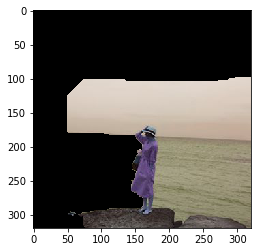

In [39]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('Grab2.jpg')

mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)
rect = (50, 50, 300, 300)  # = (x, y, w, h)

# (입력 이미지, 분할 결과, 경계 직사각형, 배경 모델, 전경 모델, 실행할 반복 크기, 모드)
cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
img = img * mask2[:,:,np.newaxis]

plt.imshow(img)

=> 임의로 지정하는 방식보다는 학습을 통해 객체를 인지하는 방식이 객체 범위를 좁일 수 있으므로 Grab-cut의 결과도 더 좋게 나옴